In [14]:
from bs4 import BeautifulSoup
from glob import glob
from tqdm import tqdm 
import codecs
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, chi2_kernel
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from string import punctuation

import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import os
import natsort
import numpy as np

stop_words = set(stopwords.words("russian"))

def dat_to_text(dat_path):
    with codecs.open(dat_path, 'r', 'utf-8') as f:
        url = f.readline().strip()
        soup = BeautifulSoup(f, 'lxml')
        title = soup.title.text
        
        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()    # rip it out

        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = ' '.join(chunk for chunk in chunks if chunk)
    return text.split()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def custom_tokenizer(text):

    trash = []
    for word in text:
        try:
            numb = ord(word)
            if numb >= 128:
                trash.append(word)
        except TypeError:
            continue
        
    trash = set(trash + list(stop_words))  
    tokenizer = TweetTokenizer()
    filtered_text = "".join([i for i in text if not i in punctuation]).lower().replace("\n", ' ').replace("\t", ' ').replace("\r", ' ')
    
    tokens = tokenizer.tokenize(filtered_text)
    tokens = [i for i in tokens if not i in trash and not i.startswith("https")]
    
    return tokens


In [3]:
stemmer = SnowballStemmer('russian')

def custom_stem_tokenizer(text):

  tokens = custom_tokenizer(text)
  stemmed_tokens = [stemmer.stem(w) for w in tokens]

  return stemmed_tokens

In [4]:
stemmed_vocabulary = [stemmer.stem(w) for w in vocabulary]

NameError: name 'vocabulary' is not defined

In [170]:
import ru_core_news_sm
nlp = ru_core_news_sm.load()

In [171]:
all_words = set(nlp.vocab.strings)

In [112]:
len(vocabulary)

500002

In [114]:
len(set(vocabulary).intersection(all_words))

499989

In [172]:
len(all_words)

630264

In [106]:
nlp.vocab.strings.to_bytes

<function StringStore.to_bytes>

In [198]:
def proc(text):
    text = ' '.join(text)
    text = text.replace('\n', ' ')
    text = ''.join([i for i in text if not i in punctuation + '1234567890'])
    res = []
    for i in range(len(text) // 50000 + 1):
        res += [i.lemma_.lower() for i in nlp(text[i * 50000: (i + 1) * 50000]) if not i.lemma_.lower() in stop_words and len(i.lemma_.lower()) > 1]
    return res

In [125]:
proc(all_texts[1])

In [86]:
len(stemmed_vocabulary)

500002

In [156]:
y[-5:]

array([0, 1, 0, 0, 0])

In [205]:


pbar = tqdm(natsort.natsorted(all_paths))
for file_path in pbar:
    
    basename = os.path.basename(file_path)
    
    # if os.path.exists(f"./texts/{basename}"):
    #     continue
    
    text = dat_to_text(file_path)
    
    if len(text) > 5000:
        factor = len(text) // 5000
        text = text[::factor][:5000]
        
    text = proc(text)
    
    embs = None
    filtered_text = []
    for x in text:
        try:
            embs = navec[x] if embs is None else np.vstack([embs, navec[x]])
            filtered_text.append(x)
        except KeyError:
            pass
    
    with codecs.open(f"./texts/{basename}", 'w', 'utf-8') as f:
        f.write(' '.join(filtered_text))
        
    np.save(f"./texts/{basename}".replace("dat", "npy"), embs)
    

  0%|          | 15/28026 [00:16<6:05:35,  1.28it/s] C:\Users\Alexey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
100%|██████████| 28026/28026 [7:37:30<00:00,  1.02it/s]   


In [182]:
all_texts = None
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)

for file_path in tqdm(doc_ids[:102]):
    file_path = f"texts/{file_path}.npy"
    text = np.load(file_path).mean(0)
    all_texts = text if all_texts is None else np.vstack([all_texts, text])
print(all_texts.shape)

100%|██████████| 102/102 [00:00<00:00, 332.27it/s]

(102, 300)


### tfidf

In [431]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 2
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)
# if sum(y) > len(y) / 2: y = 1 - y 
titles = pd.read_csv("docs_titles.tsv", delimiter='\t', index_col=0).loc[doc_ids[ids]]
titles['y'] = y 

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

100%|██████████| 94/94 [00:00<00:00, 9887.51it/s]


In [432]:
titles[titles['y'] == 0]

,title,y
doc_id,,
13106,20 лучших природных антибиотиков,0
13767,Дневник jenstvennorysa : LiveInternet - Россий...,0
12504,Показать содержимое по тегу: 2010 - Мир через ...,0
14300,Николай Илларионович Данилов Целебная магия да...,0
14103,Судьба ЭП20 [Архив] - Страница 14 - Форум Tra...,0
...,...,...
13142,"Чем опасен кашель при беременности, причины по...",0
13382,Лечебная сила меда - HintFox,0
12071,Детский ларингит. - Медицина - Педиатрия,0


In [ ]:
np.array(all_texts)[np.where(y)[0]]

In [274]:
[i.count('гуакамоле') > 4 for i in np.array(all_texts)[np.where(y)[0]]]

[False, False, False, False, False]

In [ ]:
np.array(all_texts)[np.where(1 - y)[0]]

In [ ]:
[i.count('нива') > 4 for i in np.array(all_texts)[np.where(1 - y)[0]]]

In [433]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_texts, y, test_size=0.15, random_state=42, stratify=y)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(X_train)))
print(len(tfidfv.vocabulary_))

X_train = tfidfv.transform(X_train)
X_test = tfidfv.transform(X_test)

X = tfidfv.transform(all_texts)

13210


In [316]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_texts, y, test_size=0.15, random_state=42, stratify=y)

cv = CountVectorizer()
cv.fit(custom_stem_tokenizer(" ".join(X_train)))
print(len(cv.vocabulary_))

X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

X = cv.transform(all_texts)

8129


In [183]:
X_train, X_test, y_train, y_test = train_test_split(all_texts, y, test_size=0.15, random_state=42, stratify=y)
X = all_texts


In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

<Axes: xlabel='one', ylabel='two'>

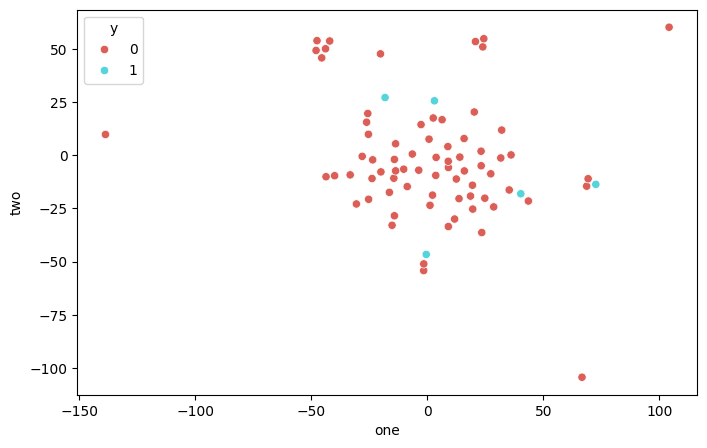

In [313]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X)
df = pd.DataFrame(X_embedded, columns=['one', 'two'])
df['y'] = y
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="one", y="two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

In [345]:
np.where(y)[0]

array([ 2, 27, 37, 41, 76], dtype=int64)

In [348]:
np.argsort(X.toarray(), axis=1)[:, -5:][np.where(y)[0]].reshape(1, -1)[0]

array([ 440, 3315, 3696, 5347, 3275, 4251, 6248,  211, 5347, 1775,  486,
       5949,  391, 2245,    0, 1230, 2933, 2372, 5685, 6787, 6787, 3275,
       7920, 5685, 4769], dtype=int64)

In [349]:
from collections import Counter

In [434]:
df_ = 1 / (tfidfv.idf_ + 0.1)

In [435]:
max_score = 0
best = None
pbar = tqdm(range(1, 25))
for n_popular in pbar:
    for n_top in range(1, 25):
        pbar.set_description(f"{n_top} / 25")
        for n_thresh in range(1, 10):
            popa = set(list(np.argsort(df_)[-n_popular:]))
            feature = [int(len(set(row).intersection(popa)) < n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
            score = f1_score(y_pred=feature, y_true=y)
            if score > max_score:
                max_score = score
                best = (n_popular, n_top, n_thresh)
                print(f"new record {max_score:.3f}, {best}")
            # accuracy_score(y_pred=feature, y_true=y) 

2 / 25:   0%|          | 0/24 [00:00<?, ?it/s]

new record 0.259, (1, 1, 1)


2 / 25:  42%|████▏     | 10/24 [00:36<00:51,  3.66s/it] 

new record 0.262, (11, 1, 1)
new record 0.267, (11, 2, 1)


8 / 25:  42%|████▏     | 10/24 [00:37<00:51,  3.66s/it]

new record 0.277, (11, 7, 1)
new record 0.283, (11, 8, 1)


10 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.289, (11, 9, 1)


12 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.295, (11, 11, 1)
new record 0.299, (11, 12, 1)


15 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.306, (11, 14, 1)
new record 0.313, (11, 15, 1)


17 / 25:  42%|████▏     | 10/24 [00:39<00:51,  3.66s/it]

new record 0.325, (11, 16, 1)


19 / 25:  42%|████▏     | 10/24 [00:39<00:51,  3.66s/it]

new record 0.338, (11, 18, 1)
new record 0.347, (11, 19, 1)


22 / 25:  42%|████▏     | 10/24 [00:40<00:51,  3.66s/it]

new record 0.351, (11, 21, 1)


23 / 25:  50%|█████     | 12/24 [00:47<00:43,  3.65s/it]

new record 0.356, (13, 22, 1)


23 / 25:  71%|███████   | 17/24 [01:05<00:25,  3.66s/it]

new record 0.361, (18, 22, 1)


24 / 25: 100%|██████████| 24/24 [01:27<00:00,  3.66s/it]


In [102]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 47
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"a
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
X = tfidfv.transform(all_texts)
df_ = 1 / (tfidfv.idf_ + 0.1)

100%|██████████| 94/94 [00:00<00:00, 592.21it/s]


In [480]:
max_score = 0
best = None
pbar = tqdm(range(1, 25))
for n_popular in pbar:
    for n_top in list(range(0, 25)) + [10000]:
        for n_thresh in range(0, 10):
            popa = set(list(np.argsort(tfidfv.idf_)[-n_popular:]))
            feature = [int(len(set(row).intersection(popa)) > n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
            score = f1_score(y_pred=feature, y_true=y)
            pbar.set_description(f"{n_top} / 25, {score:.3f}")
            if score > max_score:
                max_score = score
                best = (n_popular, n_top, n_thresh)
                print(f"new record {max_score:.3f}, {best}")
            # accuracy_score(y_pred=feature, y_true=y) 

0 / 25, 0.000:   0%|          | 0/24 [00:00<?, ?it/s]

new record 0.147, (1, 0, 0)


10000 / 25, 0.000:   0%|          | 0/24 [00:09<?, ?it/s]

new record 0.148, (1, 10000, 0)


10000 / 25, 0.147: 100%|██████████| 24/24 [04:02<00:00, 10.11s/it]


In [492]:
from sklearn.metrics.pairwise import cosine_similarity

In [516]:
mean_vector = np.asarray(X.mean(0))

In [517]:
similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]

In [532]:
def impurity(x):
    value_counts = dict(Counter(x))
    n = len(x)
    enthopy = 0
    for key in value_counts.keys():
        enthopy -= (value_counts[key] / n) * np.log(value_counts[key] / n) 
    return enthopy

def div_samples(x, y, threshold):
    
    left_mask = x > threshold
    right_mask = ~left_mask
    return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

def find_threshold(x, y):
    
    max_score = -float('inf')
    best_feature = None
    best_threshold = None

    heterogeneity_all = impurity(y)
    n = x.shape[0]

    values = sorted(list(set(x)))
    for thres in values[:-1]:
        x_left, x_right, y_left, y_right = __div_samples(x, y, thres)

        heterogeneity_left = x_left.shape[0] / n * impurity(y_left)
        heterogeneity_right = x_right.shape[0] / n * impurity(y_right)
        score = heterogeneity_all - heterogeneity_left - heterogeneity_right
        if score > max_score:
            max_score = score
            best_feature = feature
            best_threshold = thres 

    return best_threshold

In [534]:
all_preds = []
for GROUP in tqdm(range(1, 130)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]
    y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)

    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    df_ = 1 / (tfidfv.idf_ + 0.1)
    
    
    mean_vector = np.asarray(X.mean(0))
    
    best_thresh = find_threshold(np.array(similarities), y)
    feature = [int(i > best_thresh) for i in similarities]
    score = f1_score(y_pred=feature, y_true=y)
    all_preds.append([best_thresh, score])
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 129/129 [09:29<00:00,  4.41s/it]


In [537]:
all_preds = np.array(all_preds)
all_preds[:, 1] /= sum(all_preds[:, 1])

In [541]:
best_thresh = sum([i * j for i, j in all_preds])

In [547]:
best_thresh = 0.5

In [548]:
all_preds = []
all_confs = []
for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]
    # y = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)  
    
    mean_vector = np.asarray(X.mean(0))
    similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]
    all_confs = all_confs + similarities
    
    # best_thresh = find_threshold(np.array(similarities), y)
    feature = [int(i > best_thresh) for i in similarities]
    # score = f1_score(y_pred=feature, y_true=y)
    all_preds = all_preds + feature
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [13:57<00:00,  4.65s/it]


In [7]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

In [550]:
data = pd.DataFrame(np.vstack([pairs, all_preds]).T, columns=['pair_id', 'target'])
data.to_csv('submission_cosine_3.csv', index=False)

In [560]:
all_preds = {i: [] for i in np.linspace(0.1, 0.9, 9)}
for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]
    # y = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)
    similarities = np.loadtxt("confs.csv", delimiter=',', skiprows=1, usecols=[1])[ids].astype(float)

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)  
            
    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    
    mean_vector = np.asarray(X.mean(0))
    
    for thresh in np.linspace(0.1, 0.9, 9):
    
        feature = [int(i < thresh) for i in similarities]
        all_preds[thresh] = all_preds[thresh] + feature

100%|██████████| 180/180 [13:56<00:00,  4.65s/it]


In [566]:
all_preds = []
for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)

    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    df_ = 1 / (tfidfv.idf_ + 0.1)
    
    n_thresh = 1
    n_popular = 1
    n_top = 1
    popa = set(list(np.argsort(df_)[-n_popular:]))
    feature = [len(set(row).intersection(popa))  for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
    all_preds = all_preds + feature
    # score = f1_score(y_pred=feature, y_true=y)
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [13:51<00:00,  4.62s/it]


In [567]:
data = pd.DataFrame(np.vstack([pairs, all_preds]).T, columns=['pair_id', 'feature_1'])
data.to_csv('feature_1.csv', index=False)

In [9]:
for thresh in np.linspace(0.1, 0.9, 9):
    targets = 1 - np.loadtxt(f'submission_{round(thresh, 2)}.csv', delimiter=',', skiprows=1, usecols=[1])
    
    data = pd.DataFrame(np.vstack([pairs, targets]).T, columns=['pair_id', 'target']).astype(int)
    data.to_csv(f'submission_{round(thresh, 2)}_less.csv', index=False)

  0%|          | 0/129 [00:00<?, ?it/s]

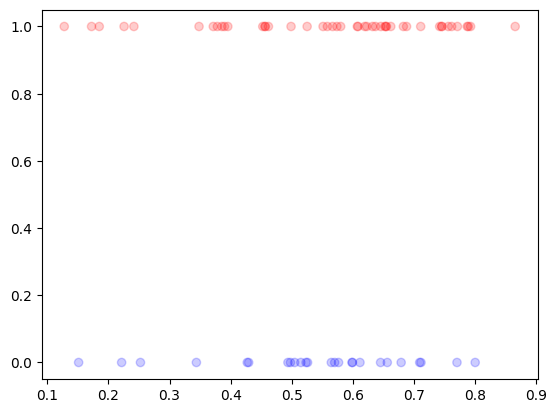

  5%|▍         | 6/129 [00:00<00:02, 42.70it/s]

6: 0.648


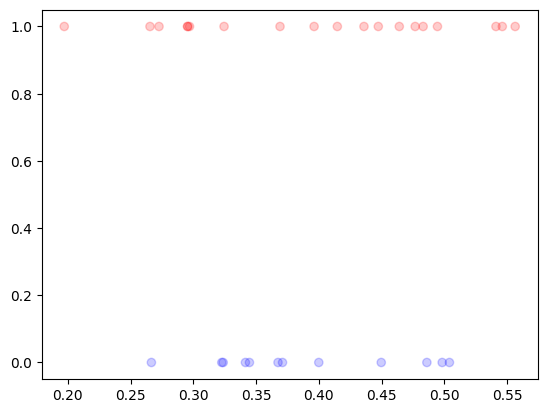

  9%|▊         | 11/129 [00:00<00:02, 45.32it/s]

9: 0.613


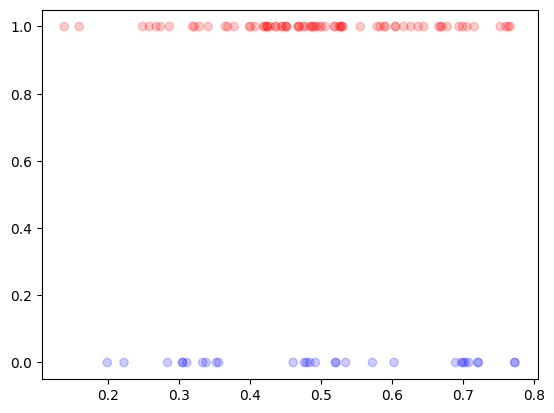

 13%|█▎        | 17/129 [00:00<00:02, 47.47it/s]

17: 0.716


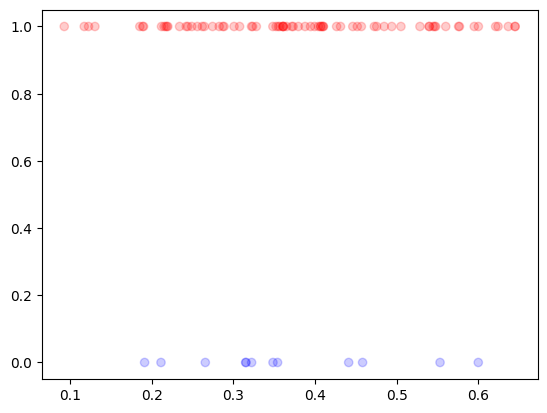

 17%|█▋        | 22/129 [00:00<00:02, 47.90it/s]

22: 0.862


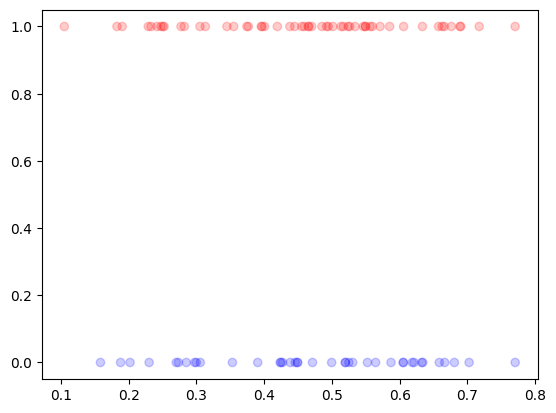

23: 0.581


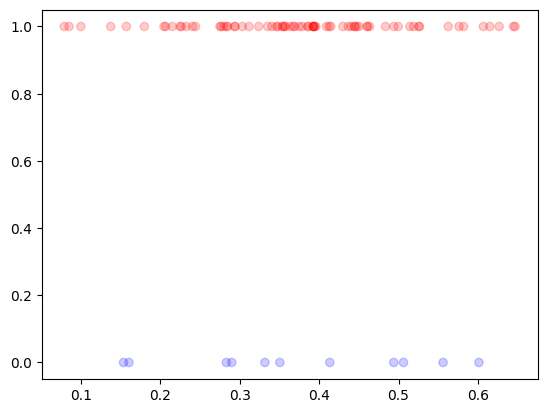

25: 0.869


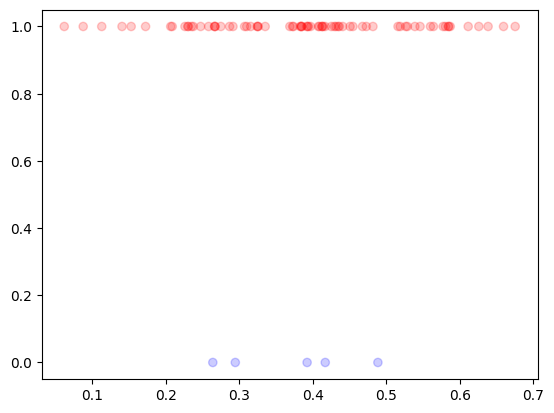

 21%|██        | 27/129 [00:00<00:03, 33.78it/s]

26: 0.937


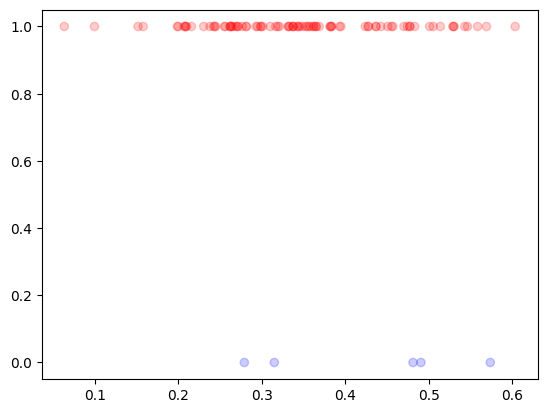

 26%|██▌       | 33/129 [00:00<00:02, 37.88it/s]

33: 0.946


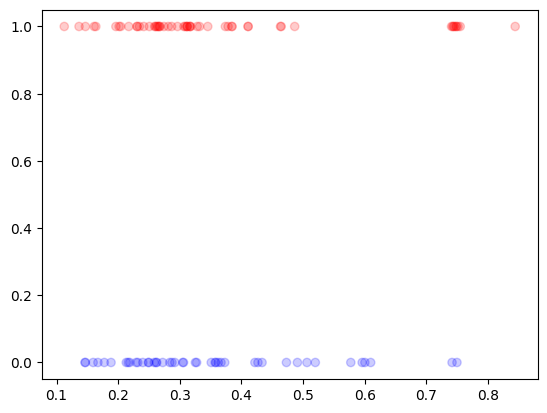

34: 0.551


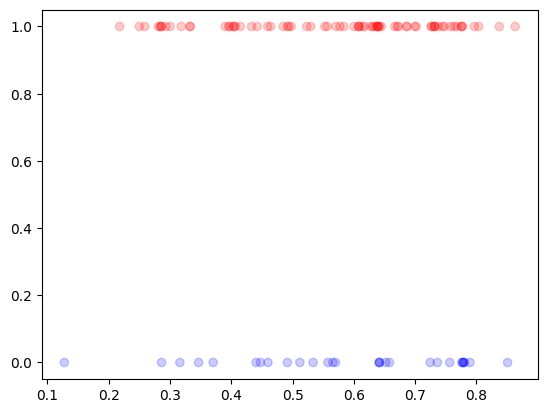

36: 0.718


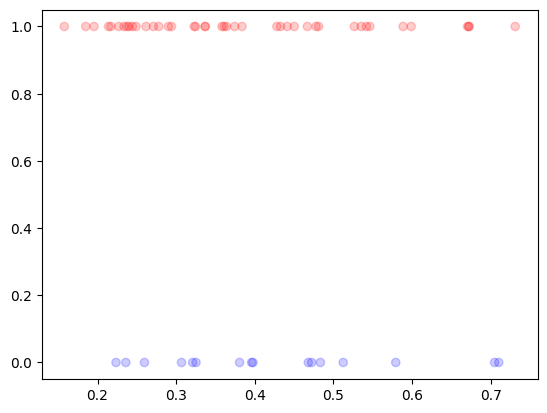

 29%|██▉       | 38/129 [00:01<00:02, 31.47it/s]

37: 0.724


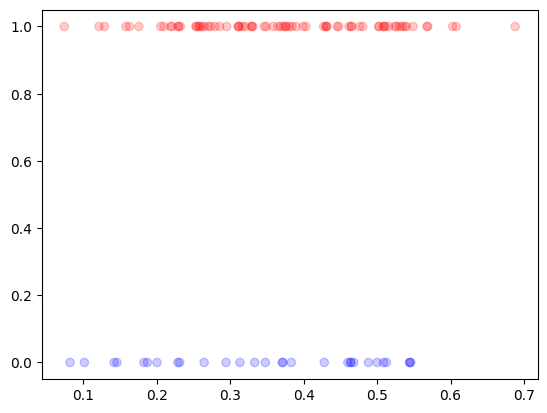

 33%|███▎      | 42/129 [00:01<00:04, 20.79it/s]

42: 0.718


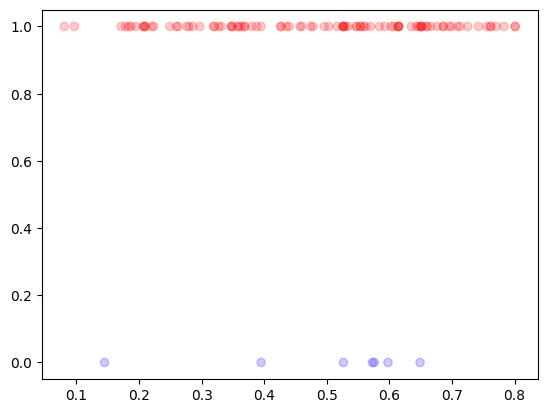

 38%|███▊      | 49/129 [00:01<00:03, 26.55it/s]

49: 0.930


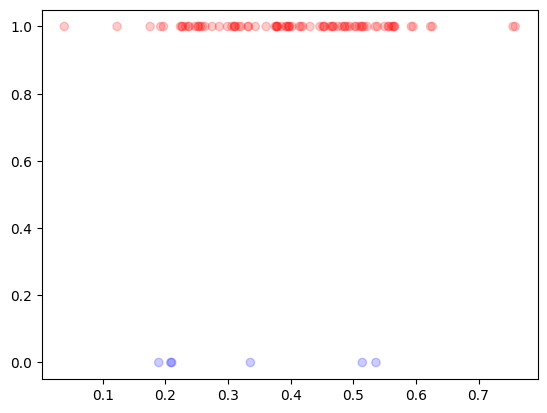

50: 0.932


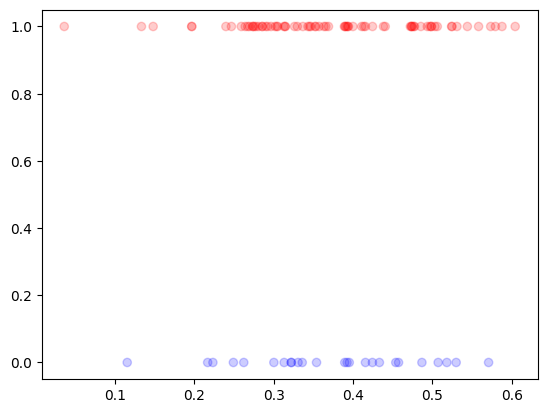

52: 0.747


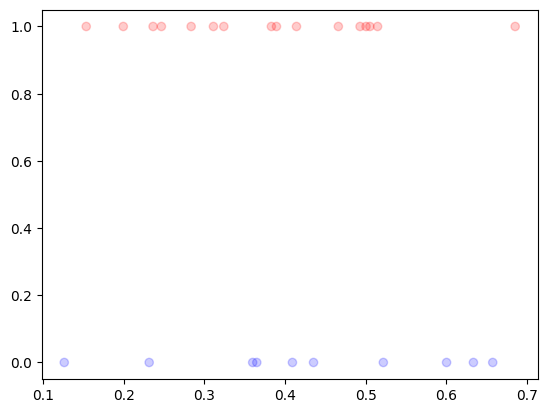

 41%|████      | 53/129 [00:01<00:03, 24.34it/s]

53: 0.615


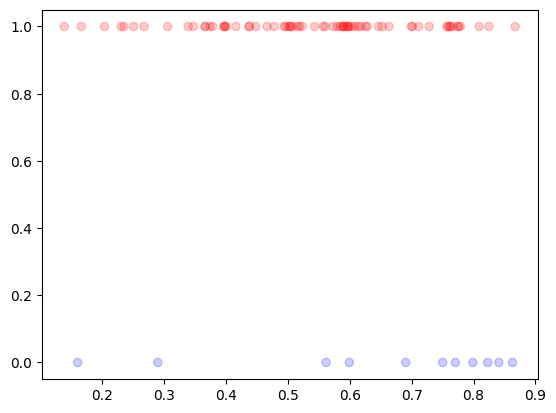

 47%|████▋     | 60/129 [00:01<00:02, 30.51it/s]

60: 0.864


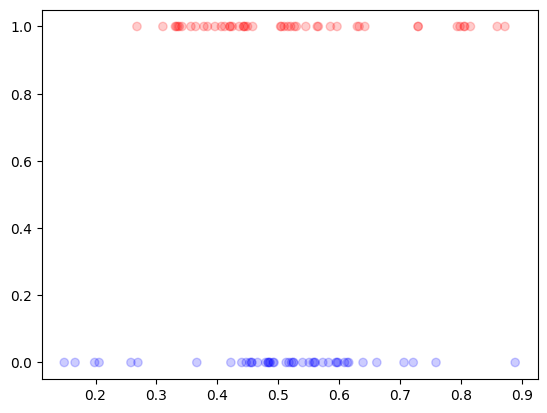

 52%|█████▏    | 67/129 [00:02<00:01, 35.75it/s]

67: 0.511


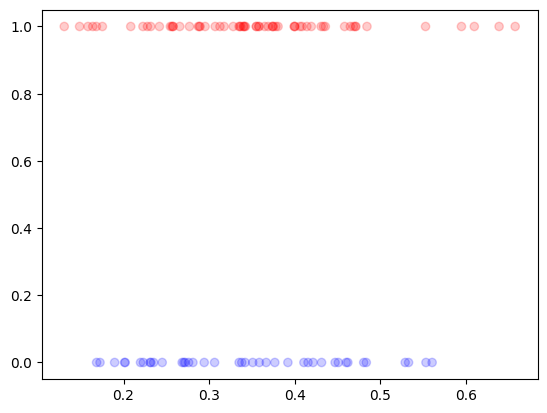

 56%|█████▌    | 72/129 [00:02<00:01, 37.64it/s]

69: 0.615


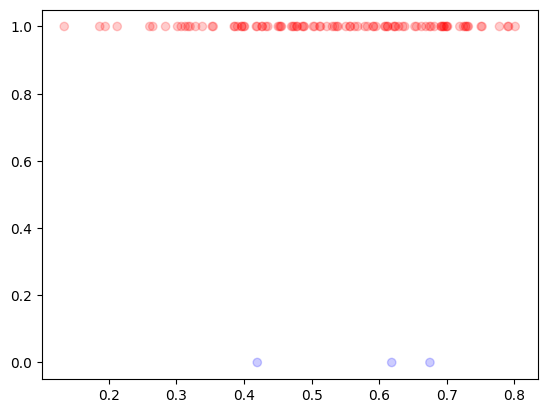

 60%|█████▉    | 77/129 [00:02<00:01, 39.41it/s]

77: 0.970


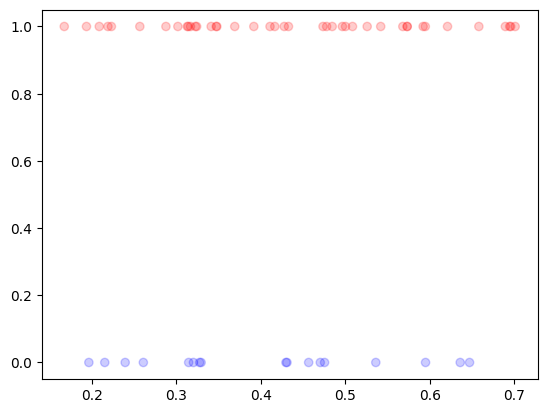

 64%|██████▎   | 82/129 [00:02<00:01, 40.96it/s]

80: 0.707


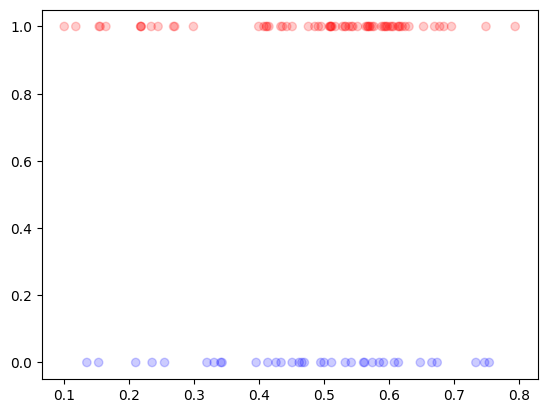

85: 0.657


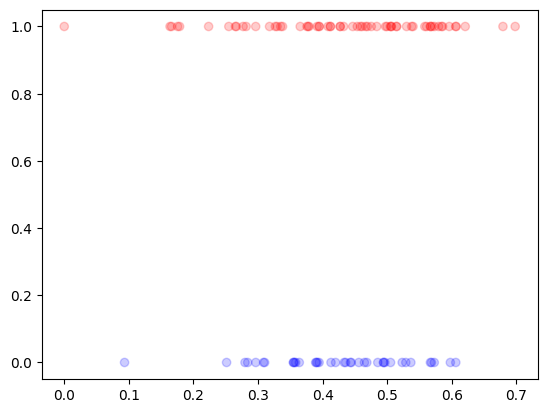

86: 0.624


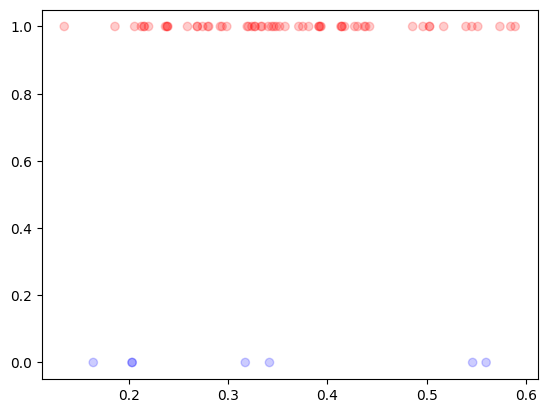

 67%|██████▋   | 87/129 [00:02<00:01, 33.97it/s]

87: 0.896


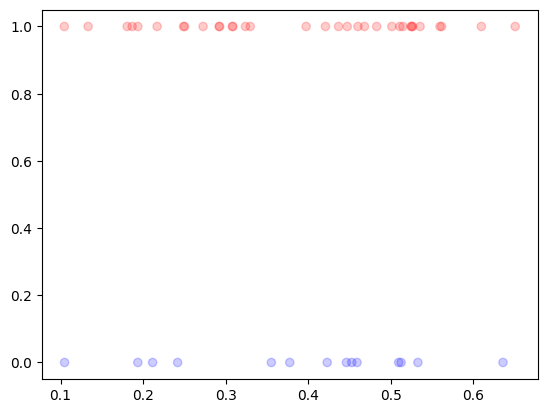

 71%|███████▏  | 92/129 [00:02<00:01, 36.84it/s]

91: 0.702


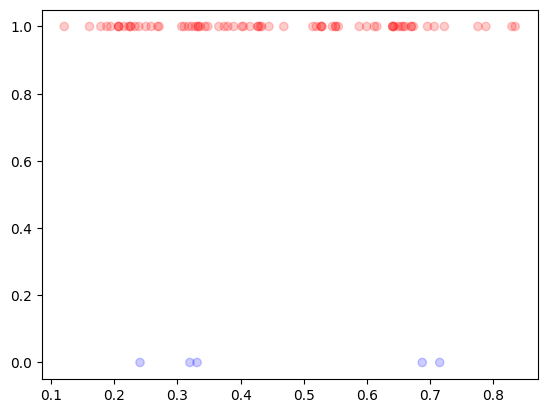

 78%|███████▊  | 100/129 [00:02<00:00, 41.90it/s]

100: 0.935


 84%|████████▍ | 109/129 [00:02<00:00, 52.95it/s]

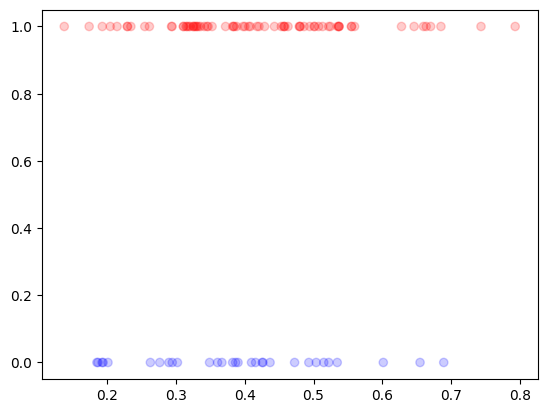

110: 0.709


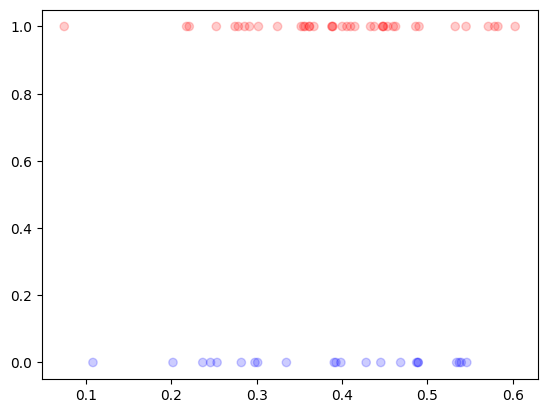

 89%|████████▉ | 115/129 [00:03<00:00, 46.80it/s]

115: 0.639


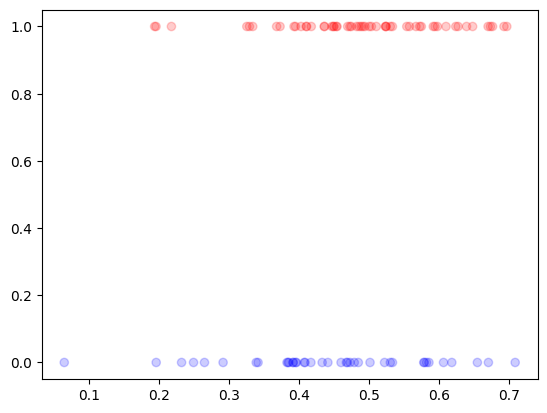

118: 0.585


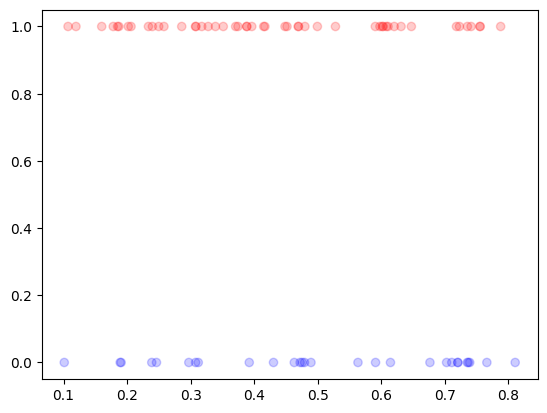

119: 0.636


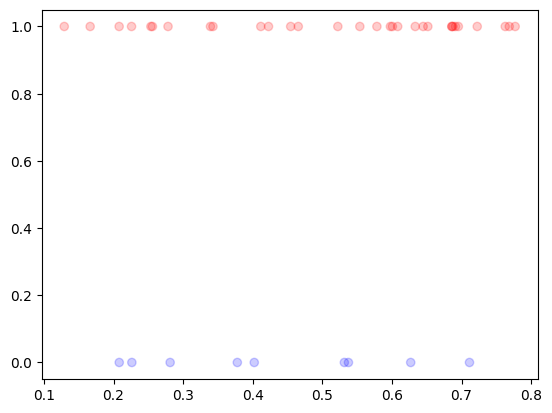

120: 0.775


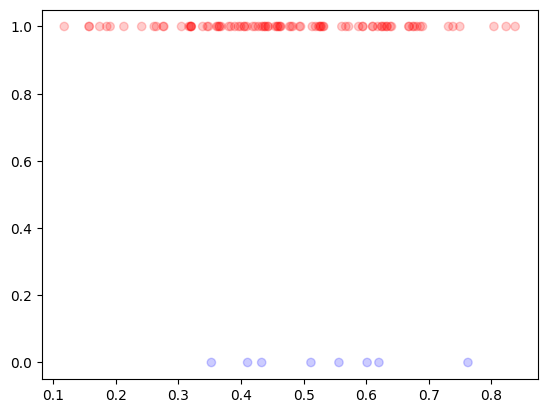

 94%|█████████▍| 121/129 [00:03<00:00, 35.67it/s]

121: 0.919


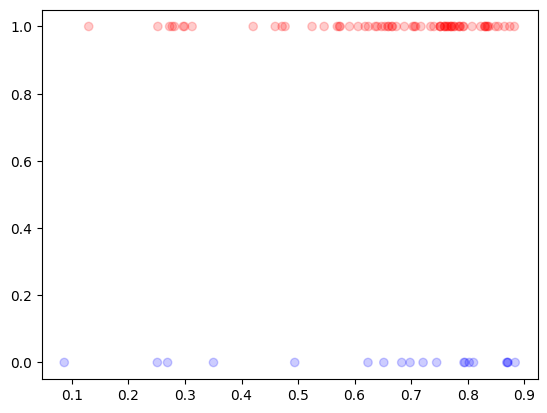

123: 0.784


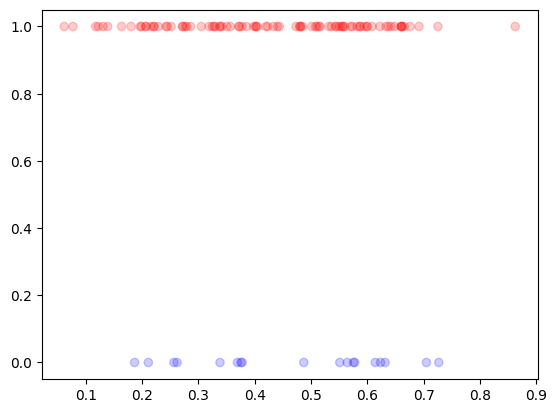

124: 0.832


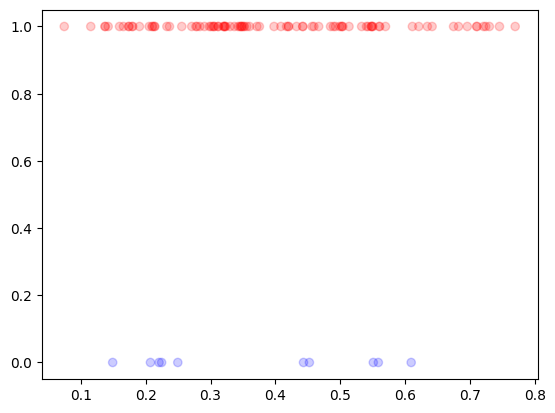

 98%|█████████▊| 126/129 [00:03<00:00, 29.65it/s]

126: 0.903


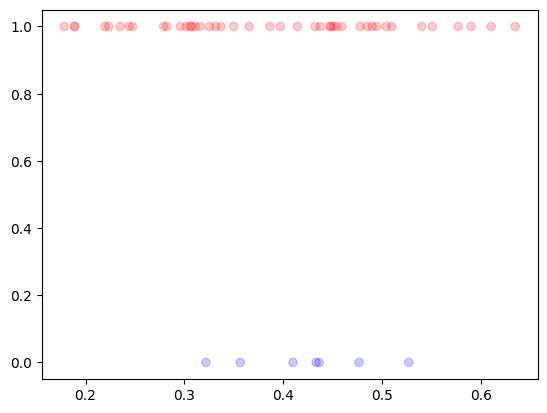

100%|██████████| 129/129 [00:03<00:00, 34.64it/s]

128: 0.860


In [559]:
for GROUP in tqdm(range(1, 130)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]
    y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)
    similarities = np.loadtxt("confs.csv", delimiter=',', skiprows=1, usecols=[1])[ids].astype(float)
    if sum(y)/len(y) > 0.5:
        plt.scatter(similarities, y, color=['r' if i else 'b' for i in y ], alpha=0.2)
        plt.show()
        print(F"{GROUP}: {sum(y)/len(y):.3f}")

In [12]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, chi2_kernel

In [171]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 118
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
X = tfidfv.transform(all_texts)
df_ = 1 / (tfidfv.idf_ + 0.1)

100%|██████████| 94/94 [00:00<00:00, 9999.10it/s]


In [172]:
cc = cosine_similarity(X.toarray())
cc *= (1 - np.eye(X.shape[0]))

In [179]:
cc = euclidean_distances(X.toarray())
cc += np.eye(X.shape[0]) * 10

In [180]:
idx = np.where(y)[0]
idx2 = np.where(1 -y)[0]

<Axes: ylabel='Density'>

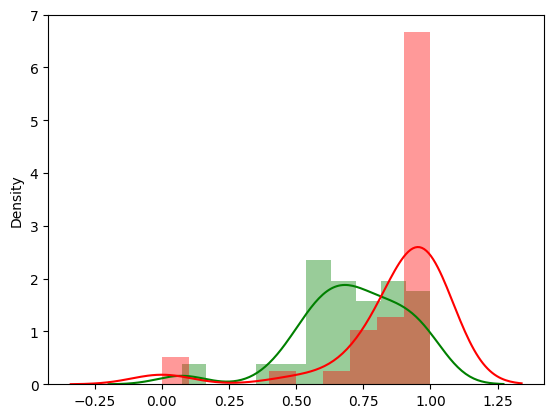

In [182]:
import warnings
warnings.filterwarnings('ignore')

hist1 = cc.min(1)[idx]
hist2 = cc.min(1)[idx2]
h1 = sns.distplot(hist1, color='green', bins=10)
sns.distplot(hist2, color='red', bins=10)


<Axes: ylabel='Density'>

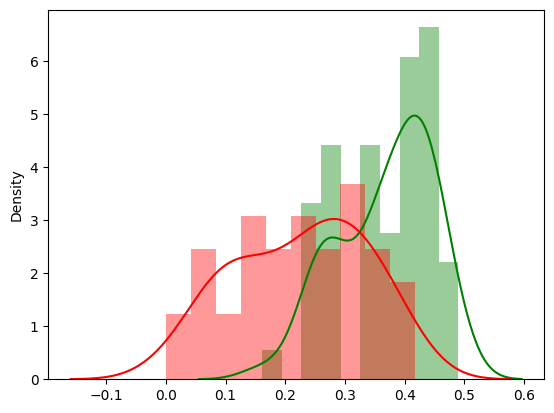

In [165]:
hist1 = cc.mean(1)[idx]
hist2 = cc.mean(1)[idx2]
sns.distplot(hist1, color='green', bins=10)
sns.distplot(hist2, color='red', bins=10)

In [185]:
all_features_1 = []
all_cosines = [] 
all_max_cosines = []
all_mean_cosines = []
all_max_chi2 = []
all_mean_chi2 = []
all_eucl = []

for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)

    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    df_ = 1 / (tfidfv.idf_ + 0.1)

    n_thresh = 1
    n_popular = 1
    n_top = 1
    popa = set(list(np.argsort(df_)[-n_popular:]))
    feature = [int(len(set(row).intersection(popa)) < n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
    all_features_1 = all_features_1 + feature
    
    mean_vector = np.asarray(X.mean(0))
    similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]
    all_cosines = all_cosines + similarities
    
    sim_matrix = cosine_similarity(X.toarray())
    sim_matrix *= (1 - np.eye(X.shape[0]))
    all_max_cosines = all_max_cosines + list(sim_matrix.max(1))
    all_mean_cosines = all_mean_cosines + list(sim_matrix.mean(1))
    
    chi2_matrix = chi2_kernel(X.toarray())
    chi2_matrix *= (1 - np.eye(X.shape[0]))
    all_max_chi2 = all_max_chi2 + list(chi2_matrix.max(1))
    all_mean_chi2 = all_mean_chi2 + list(chi2_matrix.mean(1))
    
    euclidean = euclidean_distances(X.toarray())
    euclidean += np.eye(X.shape[0]) * 10
    all_eucl = all_eucl + list(euclidean.min(1))
    
    # score = f1_score(y_pred=feature, y_true=y)
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [13:14<00:00,  4.41s/it]


In [186]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)
data = pd.DataFrame(np.vstack([pairs, all_eucl]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_eucl.csv', index=False)

In [81]:
all_features_1 = []
all_cosines = [] 
all_max_cosines = []
all_mean_cosines = []
all_max_chi2 = []
all_mean_chi2 = []

for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)

    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    df_ = 1 / (tfidfv.idf_ + 0.1)

    n_thresh = 1
    n_popular = 1
    n_top = 1
    popa = set(list(np.argsort(df_)[-n_popular:]))
    feature = [int(len(set(row).intersection(popa)) < n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
    all_features_1 = all_features_1 + feature
    
    mean_vector = np.asarray(X.mean(0))
    similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]
    all_cosines = all_cosines + similarities
    
    sim_matrix = cosine_similarity(X.toarray())
    sim_matrix *= (1 - np.eye(X.shape[0]))
    all_max_cosines = all_max_cosines + list(sim_matrix.max(1))
    all_mean_cosines = all_mean_cosines + list(sim_matrix.mean(1))
    
    chi2_matrix = chi2_kernel(X.toarray())
    chi2_matrix *= (1 - np.eye(X.shape[0]))
    all_max_chi2 = all_max_chi2 + list(chi2_matrix.max(1))
    all_mean_chi2 = all_mean_chi2 + list(chi2_matrix.mean(1))
    
    # score = f1_score(y_pred=feature, y_true=y)
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [13:20<00:00,  4.45s/it]


In [82]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

In [83]:
data = pd.DataFrame(np.vstack([pairs, all_features_1]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_feature_1.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_max_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_max_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_mean_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_mean_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_max_chi2]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_max_chi2.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_mean_chi2]).T, columns=['pair_id', 'value'])
data.to_csv('features/test/test_mean_chi2.csv', index=False)

In [188]:
feat_1 = np.loadtxt('features/train/train_feature_1.csv', delimiter=',', skiprows=1, usecols=[1])
feat_2 = np.loadtxt('features/train/train_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features/train/train_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features/train/train_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features/train/train_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features/train/train_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features/train/train_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

groups = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3]).astype(int)
trains = pd.DataFrame(np.vstack([groups, feat_1, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7, y]).T, 
                     columns=['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl', 'y'])

In [189]:
feat_1 = np.loadtxt('features/test/test_feature_1.csv', delimiter=',', skiprows=1, usecols=[1])
feat_2 = np.loadtxt('features/test/test_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features/test/test_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features/test/test_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features/test/test_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features/test/test_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features/test/test_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

subm_1 = (feat_2 > 0.5).astype(int)
groups = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
tests = pd.DataFrame(np.vstack([groups, feat_1, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7]).T, 
                     columns=['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl'])

In [190]:
trains

,groups,feat_1,cosines,max_cosines,mean_cosines,max_chi2,mean_chi2,eucl,y
0,1.0,1.0,0.521166,0.932945,0.192518,1.198959e-01,3.007209e-03,0.366209,0.0
1,1.0,1.0,0.505048,0.854709,0.186261,5.580970e-02,2.819831e-03,0.539057,0.0
2,1.0,1.0,0.201541,0.497853,0.068437,1.126110e-02,6.426828e-04,1.002145,0.0
3,1.0,0.0,0.596687,0.779414,0.221836,5.473449e-03,5.137912e-04,0.664208,0.0
4,1.0,1.0,0.537996,0.664296,0.199052,5.288895e-03,4.014840e-04,0.819395,0.0
...,...,...,...,...,...,...,...,...,...
11685,129.0,1.0,0.249314,0.286797,0.077807,1.610774e-04,1.338268e-05,1.194322,0.0
11686,129.0,1.0,0.178104,0.305238,0.052445,8.420643e-08,1.092573e-08,1.178781,0.0
11687,129.0,1.0,0.457982,0.313762,0.152126,5.946014e-09,7.660163e-10,1.171527,0.0
11688,129.0,1.0,0.365622,0.588345,0.119231,2.114201e-05,2.850339e-06,0.907365,0.0


In [63]:
from sklearn.model_selection import train_test_split

train_groups, test_groups = train_test_split(np.arange(1, 130), test_size=0.15, random_state=69)

In [64]:
trains = None
for group in train_groups:
    df_ = dataf[dataf['groups'] == group]
    trains = df_ if trains is None else pd.concat([trains, df_], axis=0)

In [65]:
tests = None
for group in test_groups:
    df_ = dataf[dataf['groups'] == group]
    tests = df_ if tests is None else pd.concat([tests, df_], axis=0)

In [191]:
X_train = trains.iloc[:, 1:-1].values
y_train = trains.iloc[:, -1].values
X_test = tests.iloc[:, 1:].values
# y_test = tests.iloc[:, -1].values

In [192]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [124]:
tree = DecisionTreeClassifier(max_depth=1)
forest = RandomForestClassifier(max_depth=5)
lr = LogisticRegression()

model = forest
model.fit(X_train, y_train)
preds = model.predict(X_test)



print(f"Train: f1_score: {f1_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, accuracy: {accuracy_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, ")
# print(f"Test: f1_score: {f1_score(y_pred=preds, y_true=y_test):.3f}, accuracy: {accuracy_score(y_pred=preds, y_true=y_test):.3f}, ")

Train: f1_score: 0.593, accuracy: 0.798, 


In [130]:
tree_1 = DecisionTreeClassifier(max_depth=5)
tree_2 = DecisionTreeClassifier(max_depth=1)
forest_1 = RandomForestClassifier(max_depth=5)


model = tree_1
model.fit(X_train, y_train)
subm_2_test = model.predict(X_test)
subm_2_train = model.predict(X_train)

model = tree_2
model.fit(X_train, y_train)
subm_3_test = model.predict(X_test)
subm_3_train = model.predict(X_train)

model = forest_1
model.fit(X_train, y_train)
subm_4_test = model.predict(X_test)
subm_4_train = model.predict(X_train)

trains['subm_1'] = (trains['feat_1'] > 0.5).astype(int)
tests['subm_1'] = (tests['feat_1'] > 0.5).astype(int)
trains['subm_2'] = subm_2_train
tests['subm_2'] = subm_2_test
trains['subm_3'] = subm_3_train
tests['subm_3'] = subm_3_test
trains['subm_4'] = subm_4_train
tests['subm_4'] = subm_4_test

trains = trains[['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'subm_1', 'subm_2', 'subm_3', 'subm_4', 'y']]
tests = tests[['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'subm_1', 'subm_2', 'subm_3', 'subm_4']]
X_train = trains.iloc[:, 1:-1].values
y_train = trains.iloc[:, -1].values
X_test = tests.iloc[:, 1:].values
# y_test = tests.iloc[:, -1].values

In [199]:
tree = DecisionTreeClassifier(max_depth=5)
forest = RandomForestClassifier(max_depth=5)
lr = LogisticRegression()
boosting = XGBClassifier(max_depth=5)

model = boosting
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f"Train: f1_score: {f1_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, accuracy: {accuracy_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, ")
# print(f"Test: f1_score: {f1_score(y_pred=preds, y_true=y_test):.3f}, accuracy: {accuracy_score(y_pred=preds, y_true=y_test):.3f}, ")

Train: f1_score: 0.748, accuracy: 0.870, 


In [204]:
!pip install scikit-learn==1.2.2

In [205]:
from featurewiz import featurewiz


ImportError: cannot import name '_check_fit_params' from 'sklearn.utils.validation' (C:\Users\Alexey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py)

In [201]:
feats = featurewiz(X_train, y_train, corr_limit=0.7, verbose=0)
len(feats)

NameError: name 'featurewiz' is not defined

In [200]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

data = pd.DataFrame(np.vstack([pairs, preds]).T, columns=['pair_id', 'target']).astype(int)
data.to_csv('submissions/3005/boosting_4_md5_eucl.csv', index=False)

In [157]:
preds

array([0., 0., 0., ..., 1., 1., 1.])

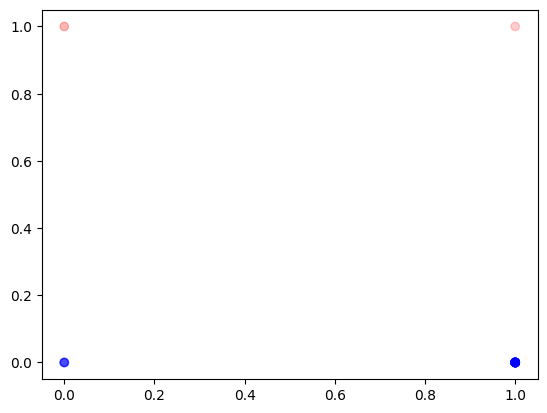

In [415]:
plt.scatter(feature, y, color=['r' if i else 'b' for i in y ], alpha=0.1)

In [295]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [324]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
tree.fit(X_train, y_train)
preds = tree.predict(X_test)
f1_score(preds, y_test), accuracy_score(preds, y_test)

(0.0, 0.8333333333333334)

In [318]:
[i for i, j in cv.vocabulary_.items() if j in np.where(tree.feature_importances_)[0]]

['организатор']

In [280]:
boosting = GradientBoostingClassifier()
boosting.fit(X_train, y_train)
preds = boosting.predict(X_test)
f1_score(preds, y_test), accuracy_score(preds, y_test)

(0.0, 0.8571428571428571)

In [179]:
np.where(y)[0]

array([28, 34, 38, 41, 63, 82, 84, 98], dtype=int64)

In [56]:
vocabulary = navec.vocab.words

In [145]:
import os
import natsort

pbar = tqdm(natsort.natsorted(all_paths)[:5])
for file_path in pbar:
    
    basename = os.path.basename(file_path)
    
    if os.path.exists(f"./texts/{basename}"):
        continue
    
    pbar.set_description(f"Processing {len(text.split())} words")
    
    text = dat_to_text(file_path)
    text = proc(text)
    
    embs = None
    for x in text.split():
        embs = navec[x] if embs is None else np.vtack(embs, navec[x])
    
    
    with codecs.open(f"./texts/{basename}", 'w', 'utf-8') as f:
        f.write(text)
    

100%|██████████| 5/5 [00:00<?, ?it/s]


In [47]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [55]:
len(vocabulary)

500002